In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora       
from nltk.stem import WordNetLemmatizer as lemmatize

from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import numpy as np
import json, os, uuid
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/BarclaysReviews/data/final_merged_reviews_cleaned.csv")


Mounted at /content/drive


In [5]:
df = df[df['cleaned_data'].notnull() & df['customer_sentiment'].str.contains('NEGATIVE')]

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
      if sent !="":
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.cleaned_data.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['awful', 'payment', 'phone', 'slow', 'open', 'prompt', 'change', 'setting', 'payment', 'phone', 'tell', 'payment', 'phone', 'slow', 'hold', 'prompt', 'payment', 'phone']]


In [7]:


# !python3 -m spacy download en  # run in terminal once

def process_words(texts):
    texts_out = []
    #nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    i =0
    for sent in texts:
        texts_out.append(sent.split())
        print(texts_out[i])
    # remove stopwords once more after lemmatization
    #texts_out = [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts_out]    
    return texts_out

#data_ready = process_words(data_words)  # processed Text Data!
data_ready = data_words  # processed Text Data!

In [8]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install lda

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=1000,
                                           per_word_topics=True,
                                           num_topics=8)

pprint(lda_model.print_topics())

[(0,
  '0.084*"transaction" + 0.070*"fix" + 0.058*"year" + 0.033*"fine" + '
  '0.027*"statement" + 0.025*"appear" + 0.025*"notification" + 0.018*"recent" '
  '+ 0.017*"bug" + 0.017*"receive"'),
 (1,
  '0.188*"slow" + 0.089*"phone" + 0.071*"change" + 0.057*"open" + 0.044*"look" '
  '+ 0.043*"tell" + 0.023*"select" + 0.020*"later" + 0.018*"page" + '
  '0.016*"recently"'),
 (2,
  '0.071*"slow" + 0.066*"payment" + 0.062*"money" + 0.041*"month" + '
  '0.028*"set" + 0.027*"iphone" + 0.024*"update" + 0.023*"bad" + '
  '0.022*"functionality" + 0.019*"mean"'),
 (3,
  '0.069*"cheque" + 0.034*"chat" + 0.033*"customer" + 0.032*"feature" + '
  '0.029*"login" + 0.024*"service" + 0.020*"online" + 0.020*"way" + '
  '0.019*"message" + 0.018*"loginin"'),
 (4,
  '0.064*"screen" + 0.053*"device" + 0.046*"card" + 0.040*"enter" + '
  '0.038*"number" + 0.026*"register" + 0.024*"experience" + 0.020*"logino" + '
  '0.019*"process" + 0.017*"response"'),
 (5,
  '0.111*"account" + 0.035*"new" + 0.032*"help" + 0.0

In [11]:
warnings.warn('Error: A warning just appeared')
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(10)


<ipython-input-12-f30755c56c23>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.5725,"slow, phone, change, open, look, tell, select, later, page, recently","[awful, payment, phone, slow, open, prompt, change, setting, payment, phone, tell, payment, phone, slow, hold, prompt, payment, phone]"
1,1,2,0.5117,"slow, payment, money, month, set, iphone, update, bad, functionality, mean","[crash, slow, notification, anymore, contactless, payment, anymore, month, bad, update, likely, sort, notify, money]"
2,2,5,0.5650,"account, new, help, problem, issue, update, option, day, navigate, error","[bad, experience, error_message, despite, recent, version, mortgage, limiting, option, account, open, stable]"
3,3,4,0.5180,"screen, device, card, enter, number, register, experience, logino, process, response","[echo, andrea, experience, quickly, moment, random, crash, idle, screen, infinite, loading, exactly, restart, phone, open, leave, embarrassed, till, bring, card, black, screen, downslow]"
4,4,5,0.5742,"account, new, help, problem, issue, update, option, day, navigate, error","[sort, finance, issue, contactless, rlepgon, day, refresh, setting, change, setting, allow, contactless, screen, click, authorise, contactless, happen, bad]"
5,5,5,0.9515,"account, new, help, problem, issue, update, option, day, navigate, error","[list, usual, payee, transfere, leave, usual, list, saturday, add, payee, list, save, navigate, update, update, payee, disappear, help]"
6,6,0,0.5105,"transaction, fix, year, fine, statement, appear, notification, recent, bug, receive","[constant, bug, currently, crash, phone, restart, fix, fine, year, recent, update]"
7,7,4,0.6287,"screen, device, card, enter, number, register, experience, logino, process, response","[input, device, phone, number, thailand]"
8,8,0,0.5289,"transaction, fix, year, fine, statement, appear, notification, recent, bug, receive","[deposit, withdrawal, notification, deposit, withdrawal, transaction, statement]"
9,9,6,0.5536,"update, bad, transfer, balance, star, start, crash, people, force, simple","[update, april, phone, force, deep_sleep, crash, constantly, contactless, payment, inconsistent, normally, crash, rush, queue, people, issue, bad, star]"


In [ ]:
len(df_dominant_topic)

In [13]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7812,"transaction, fix, year, fine, statement, appear, notification, recent, bug, receive","[notification, fix, notification]"
1,1,0.7812,"slow, phone, change, open, look, tell, select, later, page, recently","[open, recently, open]"
2,2,0.8750,"slow, payment, money, month, set, iphone, update, bad, functionality, mean","[disable, contactless, payment, slow, honestly, end]"
3,3,0.8750,"cheque, chat, customer, feature, login, service, online, way, message, loginin","[soon, send, invoice, check, invoice, close]"
4,4,0.8250,"screen, device, card, enter, number, register, experience, logino, process, response","[impressed, prove, text, code]"
5,5,0.9515,"account, new, help, problem, issue, update, option, day, navigate, error","[list, usual, payee, transfere, leave, usual, list, saturday, add, payee, list, save, navigate, ..."
6,6,0.8296,"update, bad, transfer, balance, star, start, crash, people, force, simple","[bad, bad, bad, reallly, bad]"
7,7,0.8238,"like, great, access, etc, remove, doesn, old, point, idea, load","[like, pull, tooth, avoid]"


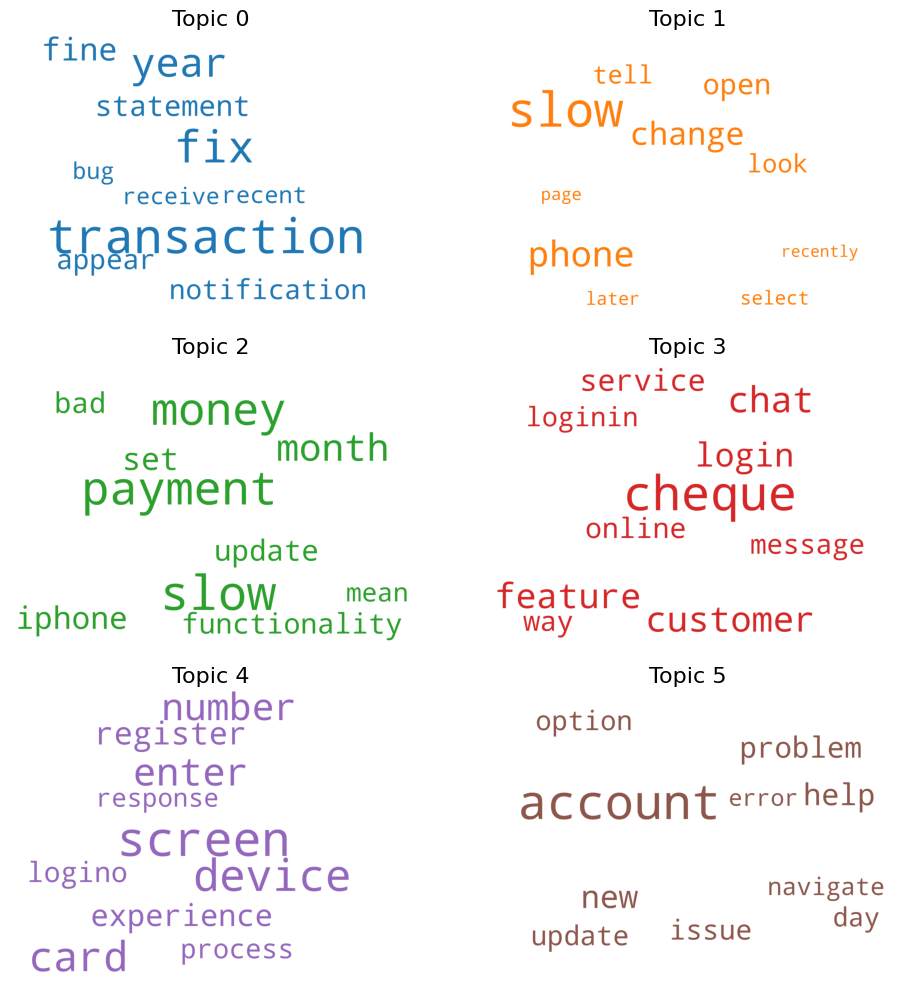

In [15]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-16-a6609d91578a>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


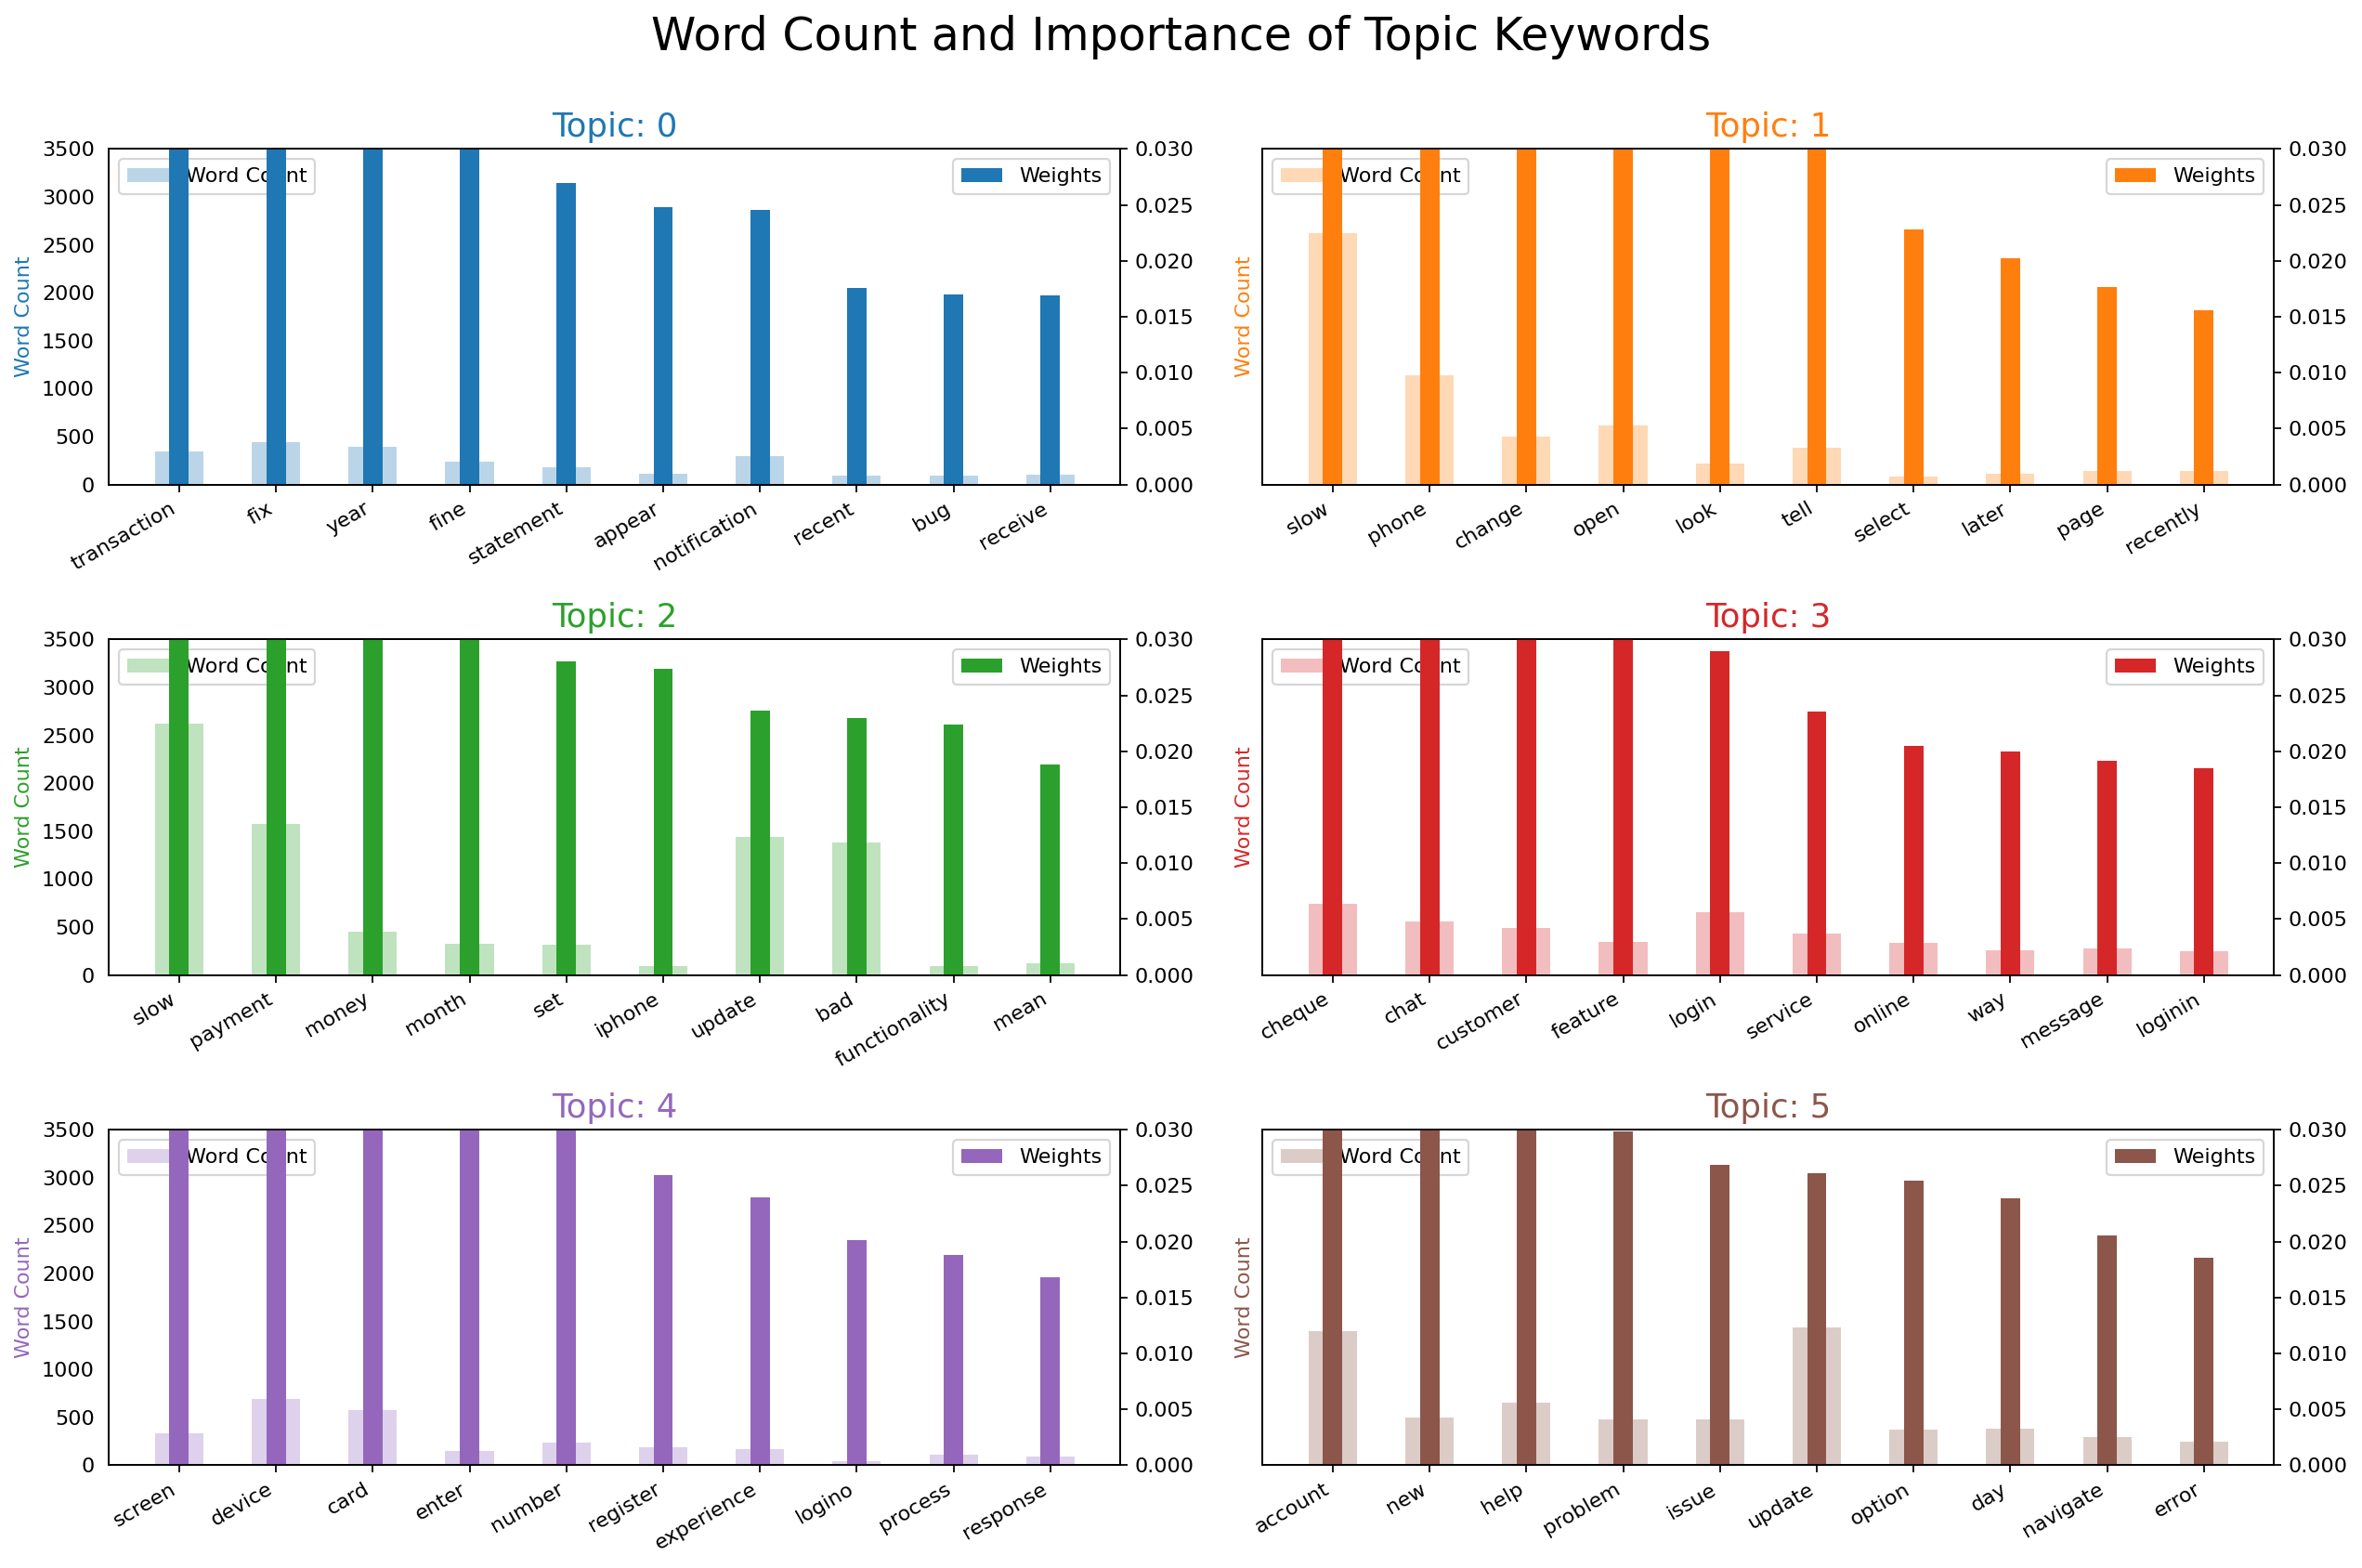

In [16]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


In [ ]:
pip install "pandas<2.0.0"

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

In [ ]:
corpus

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words.extend(['app', 'barclays','need','will','pay'])
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)